## Tibetan Chiru 16S Amplicon Sequencing Analysis
___William Sano___
___FISH546 - Dr. Stephen Roberts F18___  
___November 1, 2018___

### Make sure that you have initialized a Qiime2 (ver. 2018.8) environment in conda. Instructions [here](https://docs.qiime2.org/2018.8/tutorials/filtering/)

In [1]:
!echo $PATH
!pwd

/anaconda3/bin:/anaconda3/bin:/Users/williamsano/anaconda3/bin:/Users/williamsano/miniconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/ncbi/blast/bin:/Users/williamsano/scripts
/Users/williamsano/Documents/GitHub/will-Chiru16S


**Yue's Chiru fq.gz sent to me via email on 10.18.18, 3:27pm in Google Drive Folder.  
Files were zipped, downloaded, and placed into `./data/Yue/raw/`.  
Data then unzipped via `gunzip`**

In [3]:
!gunzip -k -q data/Yue/raw/*.fq.gz

In [5]:
!mv data/Yue/raw/*.fq data/Yue/
!ls data/Yue

raw                 raw.split.A_4.1.fq  raw.split.F_10.2.fq raw.split.F_15.1.fq
raw.split.A_2.1.fq  raw.split.A_4.2.fq  raw.split.F_11.1.fq raw.split.F_15.2.fq
raw.split.A_2.2.fq  raw.split.A_5.1.fq  raw.split.F_11.2.fq
raw.split.A_3.1.fq  raw.split.A_5.2.fq  raw.split.F_13.1.fq
raw.split.A_3.2.fq  raw.split.F_10.1.fq raw.split.F_13.2.fq


#### Running fastqc FastQC v0.11.8 on all fastq files

In [16]:
! /Applications/bioinformatics/FastQC/fastqc data/Yue/*.fq -o analyses/Yue/fastqc
! rm analyses/Yue/fastqc/*.zip

Started analysis of raw.split.A_2.1.fq
Approx 5% complete for raw.split.A_2.1.fq
Approx 10% complete for raw.split.A_2.1.fq
Approx 15% complete for raw.split.A_2.1.fq
Approx 20% complete for raw.split.A_2.1.fq
Approx 25% complete for raw.split.A_2.1.fq
Approx 30% complete for raw.split.A_2.1.fq
Approx 35% complete for raw.split.A_2.1.fq
Approx 40% complete for raw.split.A_2.1.fq
Approx 45% complete for raw.split.A_2.1.fq
Approx 50% complete for raw.split.A_2.1.fq
Approx 55% complete for raw.split.A_2.1.fq
Approx 60% complete for raw.split.A_2.1.fq
Approx 65% complete for raw.split.A_2.1.fq
Approx 70% complete for raw.split.A_2.1.fq
Approx 75% complete for raw.split.A_2.1.fq
Approx 80% complete for raw.split.A_2.1.fq
Approx 85% complete for raw.split.A_2.1.fq
Approx 90% complete for raw.split.A_2.1.fq
Approx 95% complete for raw.split.A_2.1.fq
Analysis complete for raw.split.A_2.1.fq
Started analysis of raw.split.A_2.2.fq
Approx 5% complete for raw.split.A_2.2.fq
Approx 10% complete for

#### Importing raw.split.\*.fq files into Qiime2 environment via fastq manifest format
Phred score is 33  
***!MAKE SURE THAT YOU ACTIVATE THE QIIME2 ENVIRONMENT BEFORE LAUNCHING!***

In [2]:
!qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' --input-path scripts/Chiru16S_manifest.csv --output-path data/Yue/paired-end-demux.qza --input-format PairedEndFastqManifestPhred33

Imported scripts/Chiru16S_manifest.csv as PairedEndFastqManifestPhred33 to data/Yue/paired-end-demux.qza


In [4]:
!qiime demux summarize --i-data data/Yue/paired-end-demux.qza --o-visualization data/Yue/paired-end-demux.qzv

Saved Visualization to: data/Yue/paired-end-demux.qzv


#### Based on readout from paired-end-demux.qzv file and fastqc, trimming forward and reverse reads at 15bp and pos 280 (F)/pos 265 (R) with DADA2. This step also completes denoising and chimera checking by consensus method.
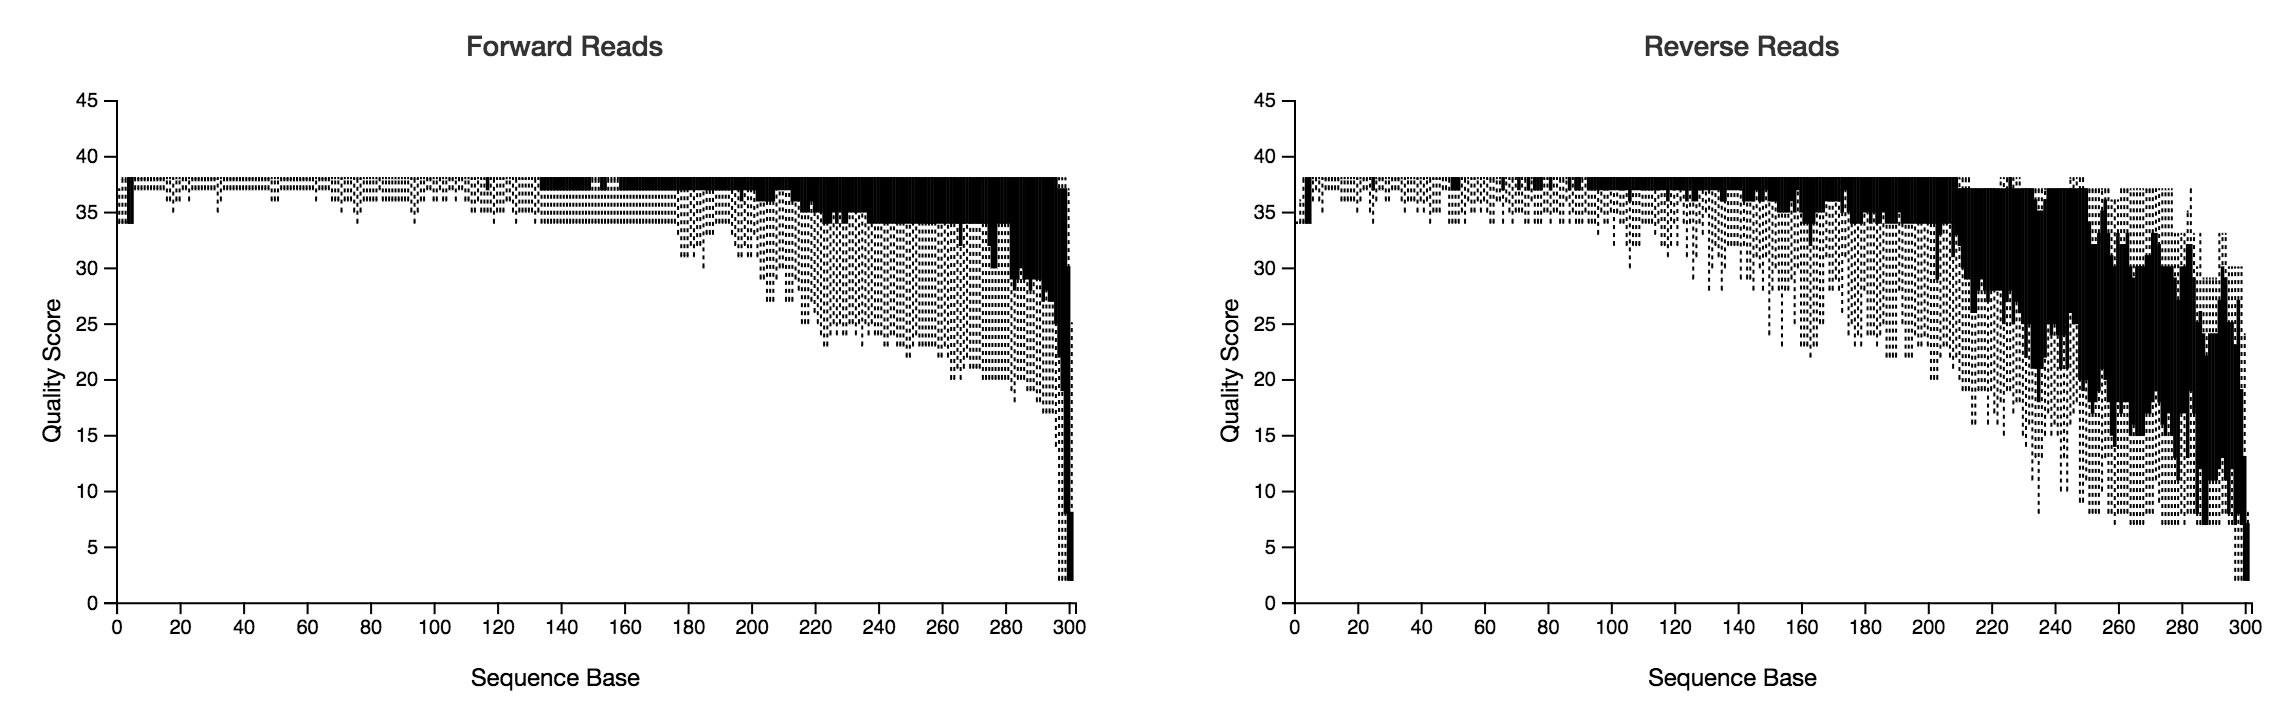

In [12]:
#paired-end denoising in DADA2
!qiime dada2 denoise-paired \
  --i-demultiplexed-seqs data/Yue/paired-end-demux.qza \
  --o-table data/Yue/pe-table.qza \
  --o-representative-sequences data/Yue/pe-rep-seqs.qza \
  --o-denoising-stats data/Yue/pe-denoising-stats.qza \
  --p-trim-left-f 15 \
  --p-trim-left-r 15 \
  --p-trunc-len-f 280 \
  --p-trunc-len-r 265

Saved FeatureTable[Frequency] to: data/Yue/table.qza
Saved FeatureData[Sequence] to: data/Yue/pe-rep-seqs.qza
Saved SampleData[DADA2Stats] to: data/Yue/pe-denoising-stats.qza


In [21]:
#single-end denoising in DADA2. Takes paired-end-demux and only reads in the forward reads
#as designated in the manifest file.
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs data/Yue/paired-end-demux.qza \
  --o-table data/Yue/se-table.qza \
  --o-representative-sequences data/Yue/se-rep-seqs.qza \
  --o-denoising-stats data/Yue/se-denoising-stats.qza \
  --p-trim-left 15 \
  --p-trunc-len 265 

### Make summary outputs  
*Highly* permissive trimming in DADA2 required to achieve 20bp overlap necessary for paired-end denoising. Therefore, created summary outputs from single-end (R1 only) and paired-end amplicon sequence variant (ASV) tables and denoising stats.  

### __single end__ - ASV table summary, representative sequences, and denoising stats

In [4]:
!qiime feature-table summarize \
  --i-table data/Yue/se-table.qza \
  --o-visualization data/Yue/se-table.qzv \
  --m-sample-metadata-file scripts/mapping.txt

!qiime feature-table tabulate-seqs \
  --i-data data/Yue/se-rep-seqs.qza \
  --o-visualization data/Yue/se-rep-seqs.qzv

!qiime metadata tabulate \
  --m-input-file data/Yue/se-denoising-stats.qza
  --o-visualization data/Yue/se-denoising-stats.qzv

Saved Visualization to: data/Yue/se-table.qzv
Saved Visualization to: data/Yue/se-rep-seqs.qzv


> ## output: `se-table.qzv`
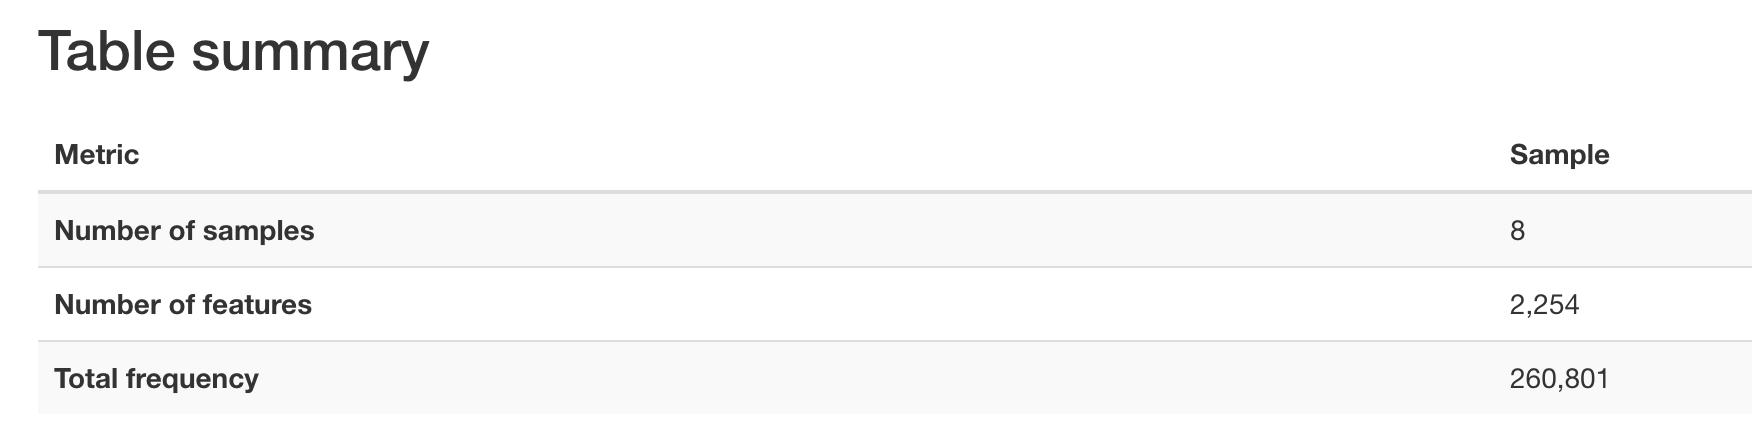

> ## output: `se-denoising-stats.qzv`
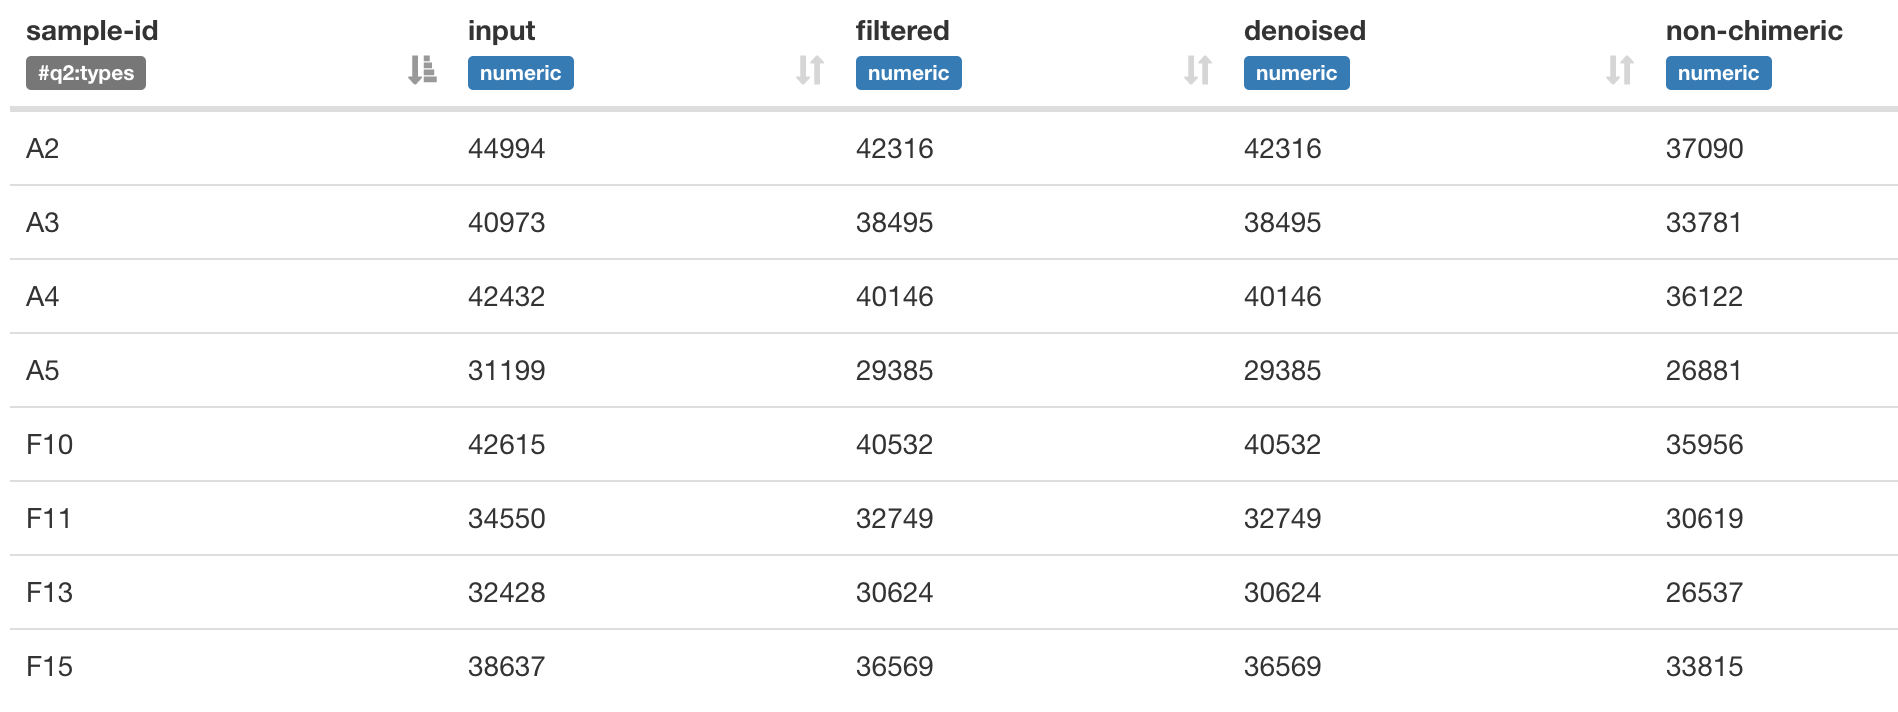

### __paired end__ - feature table summary, representative sequences, and denoising stats

In [19]:
!qiime feature-table summarize \
  --i-table data/Yue/pe-table.qza \
  --o-visualization data/Yue/pe-table.qzv \
  --m-sample-metadata-file scripts/mapping.txt

!qiime feature-table tabulate-seqs \
  --i-data data/Yue/pe-rep-seqs.qza \
  --o-visualization data/Yue/pe-rep-seqs.qzv

!qiime metadata tabulate \
  --m-input-file data/Yue/pe-denoising-stats.qza \
  --o-visualization data/Yue/pe-denoising-stats.qzv

Saved Visualization to: data/Yue/pe-table.qzv
Saved Visualization to: data/Yue/pe-rep-seqs.qzv
Saved Visualization to: data/Yue/pe-denoising-stats.qzv


> ## output: `pe-table.qzv`
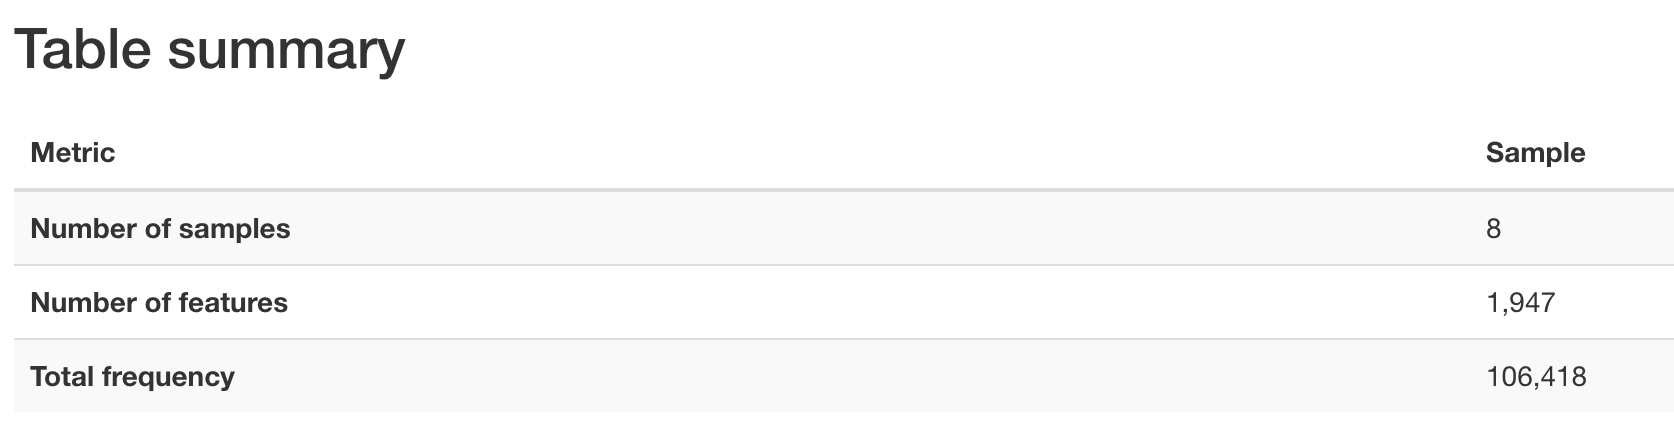

> ## output: `pe-denoising-stats.qzv`
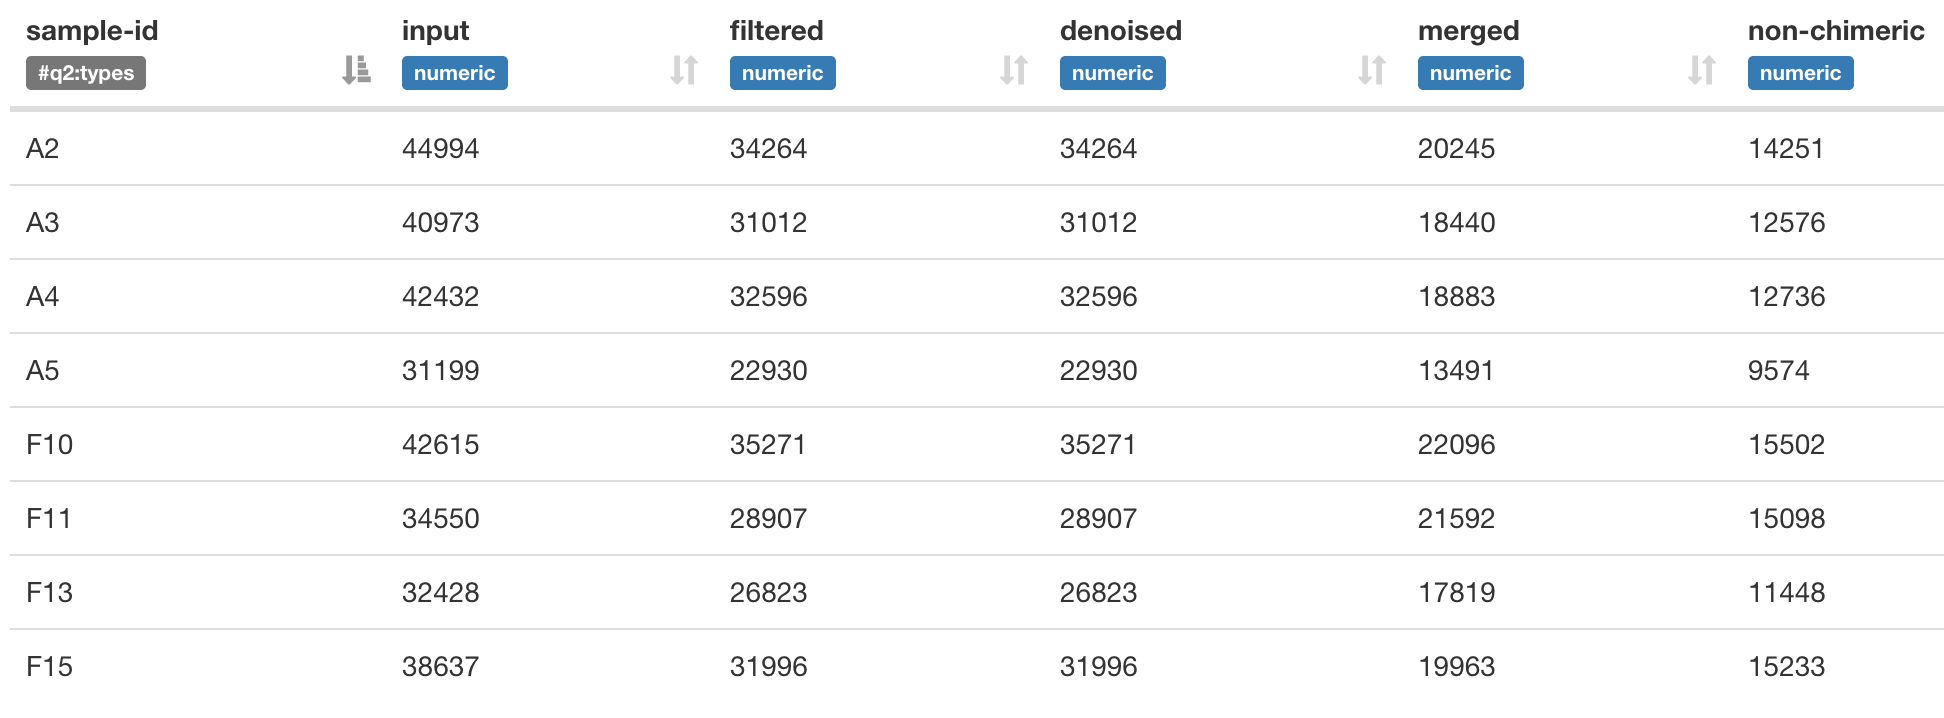

#### Retrieving SILVA 99% identity OTU naive Bayes classifier for the bacterial 16S gene

In [1]:
!wget -O "silva-132-99-nb-classifier.qza" "https://data.qiime2.org/2018.8/common/silva-132-99-nb-classifier.qza" > data/silva-132-99-nb-classifier.qza

--2018-11-01 10:17:52--  https://data.qiime2.org/2018.8/common/silva-132-99-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 104.27.171.158, 104.27.170.158
Connecting to data.qiime2.org (data.qiime2.org)|104.27.171.158|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2018.8/common/silva-132-99-nb-classifier.qza [following]
--2018-11-01 10:17:53--  https://s3-us-west-2.amazonaws.com/qiime2-data/2018.8/common/silva-132-99-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.209.200
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.209.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643767866 (614M) [binary/octet-stream]
Saving to: ‘silva-132-99-nb-classifier.qza’

silva-132-99-nb-cla 100%[===================>] 613.94M  9.14MB/s    in 55s     

2018-11-01 10:18:48 (11.1 MB/s) - ‘silva-132-99-nb-classi

#### Creating feature classifier to assign each of the reads in `rep-seqs.qza` to an OTU in SILVA.

In [2]:
!qiime feature-classifier classify-sklearn \
  --i-classifier data/silva-132-99-nb-classifier.qza \
  --i-reads data/Yue/se-rep-seqs.qza \
  --o-classification analyses/Yue/se-silva-taxonomy.qza

!qiime metadata tabulate \
  --m-input-file analyses/Yue/se-silva-taxonomy.qza \
  --o-visualization analyses/Yue/se-silva-taxonomy.qzv

Saved FeatureData[Taxonomy] to: analyses/Yue/se-silva-taxonomy.qza
Saved Visualization to: analyses/Yue/se-silva-taxonomy.qzv


In [22]:
!qiime feature-classifier classify-sklearn \
  --i-classifier data/silva-132-99-nb-classifier.qza \
  --i-reads data/Yue/pe-rep-seqs.qza \
  --o-classification analyses/Yue/pe-silva-taxonomy.qza

!qiime metadata tabulate \
  --m-input-file analyses/Yue/pe-silva-taxonomy.qza \
  --o-visualization analyses/Yue/pe-silva-taxonomy.qzv

Plugin error from feature-classifier:

  [Errno 28] No space left on device

Debug info has been saved to /var/folders/fj/lrbc9zxd0pn3ck7w0w70k6ph0000gn/T/qiime2-q2cli-err-i8s4dslv.log
There was an issue with loading the file analyses/Yue/pe-silva-taxonomy.qza as metadata:

  Metadata file path doesn't exist, or the path points to something other than a file. Please check that the path exists, has read permissions, and points to a regular file (not a directory): analyses/Yue/pe-silva-taxonomy.qza

  There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

  Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2018.8/tutorials/metadata/



#### Filter out chloroplast, mitochondrial sequences

In [6]:
!qiime taxa filter-table \
  --i-table data/Yue/se-table.qza \
  --i-taxonomy analyses/Yue/se-silva-taxonomy.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table data/Yue/se-table-excl-mitochloro.qza

!qiime feature-table summarize \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --o-visualization data/Yue/se-table-excl-mitochloro.qzv \
  --m-sample-metadata-file scripts/mapping.txt

Saved FeatureTable[Frequency] to: data/Yue/se-table-excl-mitochloro.qza
Saved Visualization to: data/Yue/se-table-excl-mitochloro.qzv


#### Making tree for phylogenetic analysis

In [7]:
!qiime alignment mafft \
  --i-sequences data/Yue/se-rep-seqs.qza \
  --o-alignment data/Yue/se-aligned-rep-seqs.qza

!qiime alignment mask \
  --i-alignment data/Yue/se-aligned-rep-seqs.qza \
  --o-masked-alignment data/Yue/se-masked-aligned-rep-seqs.qza

!qiime phylogeny fasttree \
  --i-alignment data/Yue/se-masked-aligned-rep-seqs.qza \
  --o-tree data/Yue/se-unrooted-tree.qza

!qiime phylogeny midpoint-root \
  --i-tree data/Yue/se-unrooted-tree.qza \
  --o-rooted-tree data/Yue/se-rooted-tree.qza

Saved FeatureData[AlignedSequence] to: data/Yue/se-aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: data/Yue/se-masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: data/Yue/se-unrooted-tree.qza
Saved Phylogeny[Rooted] to: data/Yue/se-rooted-tree.qza


### Phylogenetic Analyses

Sampling depth of 26537 for `core-metrics-phylogenetic` sequence rarefaction set by picking lowest sequence number per sample as shown in `se-table-excl-mitochloro.qzv`

In [11]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny data/Yue/se-rooted-tree.qza \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --p-sampling-depth 26537 \
  --output-dir analyses/Yue/se-excl-mitochloro-corediv-26537 \
  --m-metadata-file scripts/mapping.txt

Saved FeatureTable[Frequency] to: analyses/Yue/se-excl-mitochloro-corediv-26537/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: analyses/Yue/se-excl-mitochloro-corediv-26537/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: analyses/Yue/se-excl-mitochloro-corediv-26537/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: analyses/Yue/se-excl-mitochloro-corediv-26537/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: analyses/Yue/se-excl-mitochloro-corediv-26537/evenness_vector.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: analyses/Yue/se-excl-mitochloro-corediv-26537/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: analyses/Yue/se-excl-mitochloro-corediv-26537/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: analyses/Yue/se-excl-mitochloro-corediv-26537/jaccard_distance_matrix.qza
Saved DistanceMatrix to: analyses/Yue/se-excl-mitochloro-corediv-26537/bray